In [1]:
!python --version

Python 3.7.16


In [1]:
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from activity.ActingAgent import Agent
from tqdm import tqdm

In [2]:
envs = helpers.create_envs(yamls_filename='2_region_yamls', n=10)
state = envs[0].reset()
agents = [Agent(len(state[i]['features']), envs[0].action_space[i], device='cpu') 
          for i in range(envs[0].num_regions)]
#agents_negotiation = helpers.create_agents(envs[0])
#helpers.get_mean_reward(envs[0])

In [3]:
epochs = 100
batch_size = 20
episode_length = envs[0].episode_length
eval_rewards = np.zeros((epochs + 1, len(agents)))
eval_rewards[0] = helpers.eval_agents(agents, envs[0], False)

for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        states = [env.reset() for env in envs]
        
        for t in range(episode_length):
            actions = [
                agents[agent_id].act([state[agent_id] for state in states]) 
                for agent_id in range(len(agents))
            ]

            actions = [
                {
                    agent_id : actions[agent_id][env_id]
                    for agent_id in range(len(agents))
                }
                for env_id in range(len(envs))
            ]

            states, rewards, _, _ = zip(*[env.step(actions[i]) for (i, env) in enumerate(envs)])
            rewards = np.array([list(reward.values()) for reward in rewards])
            
            for i, agent in enumerate(agents):
                for env_id in range(len(envs)):
                    agent.ppo.buffer.rewards[env_id].append(rewards[env_id, i])
                    agent.ppo.buffer.is_terminals[env_id].append(t == episode_length - 1)
    for agent in agents:
        agent.update()

    eval_rewards[epoch + 1] = helpers.eval_agents(agents, envs[0], False, n_trials=100)


100%|█████████████████████████████████████████| 100/100 [17:46<00:00, 10.66s/it]


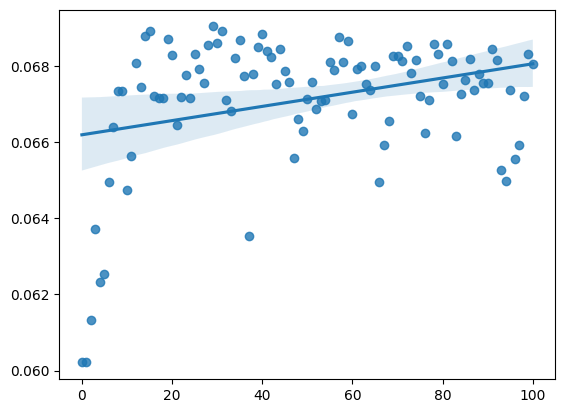

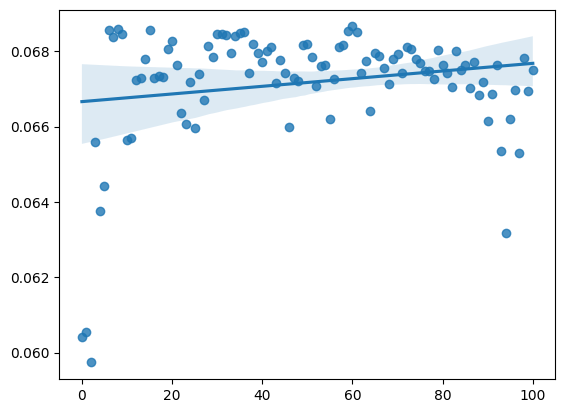

In [11]:
sns.regplot(x = np.arange(len(eval_rewards)), y = eval_rewards[:, 1])
plt.show()
sns.regplot(x = np.arange(len(eval_rewards)), y = eval_rewards[:, 0])
plt.show()